In [0]:
import numpy as np
import pandas as pd
from datetime import date
from itertools import islice

days_to_predict = 5
data_global_raw_url = 'https://raw.githubusercontent.com/cemansilla/covid-19-notebook/master/server/data/global.json'
df_cases = pd.read_json(data_global_raw_url)

#Cálculo de rango de fechas
start_date = pd.to_datetime('2020-03-04')
today_date = pd.to_datetime(date.today())
end_date = today_date + pd.to_timedelta(days_to_predict, unit="D")
cases_days = (today_date - start_date)/np.timedelta64(1,'D')
forecast_days = (end_date - start_date)/np.timedelta64(1,'D')

#Convierto la columna de fecha a datetime
df_cases['date_report'] = pd.to_datetime(df_cases['date_report'])
#Me quedo con los de Argentina y ordeno por fecha
df_cases = df_cases.loc[df_cases['country_code'].isin(['ARG'])].sort_values(by=['date_report'])
#Relleno con las fechas faltantes y datos en cero
a_dates = pd.date_range(start_date, periods=cases_days, freq='D')
df_cases = df_cases.set_index('date_report').reindex(a_dates).fillna(0.0).rename_axis('date_report').reset_index()
#Fechas de Predicción
a_dates_forecast = pd.date_range(start_date, periods=forecast_days, freq='D')

#Calculo el acumulativo por días y lo agrego al dataframe de casos / muertes
df_cases['cases_sum'] = np.cumsum(df_cases['cases'])
df_cases['deaths_sum'] = np.cumsum(df_cases['deaths'])

Cálculo del factor de incremento en base a casos confirmados

In [0]:
#Descarto n cantidad de días del principio
offset_days = 1
df_cases.loc[offset_days:]

values = []
#for i, val in enumerate(cases):
for i, row in df_cases.iterrows():
  if(i > 0 and df_cases.iloc[i-1]['cases'] > 0):
    f = df_cases.iloc[i]['cases'] / df_cases.iloc[i-1]['cases'] #Factor
    values.append(f)

#Media del factor
growth_factor = np.mean(values)

Cálculo de predicción

In [0]:
forecast = []
i = 1
while i <= forecast_days:
  get_last = False
  try:
    last_forecast = df_cases.iloc[i-1]['cases'] if df_cases.iloc[i-1]['cases'] > 0 else forecast[-1]
  except:
    last_forecast = forecast[-1]

  f = growth_factor * last_forecast
  forecast.append(f)

  i+=1

#Convierto a dataframe y agrego acumulativo de casos
df_forecast = pd.DataFrame({'cases': forecast, 'cases_sum': np.cumsum(forecast)})
#Agrego columna con fechas
df_dates = pd.DataFrame(a_dates_forecast)
df_forecast = pd.concat([df_dates, df_forecast], axis=1)
#Renombre columnas
df_forecast.columns = ['date', 'cases', 'cases_sum']

Grafico

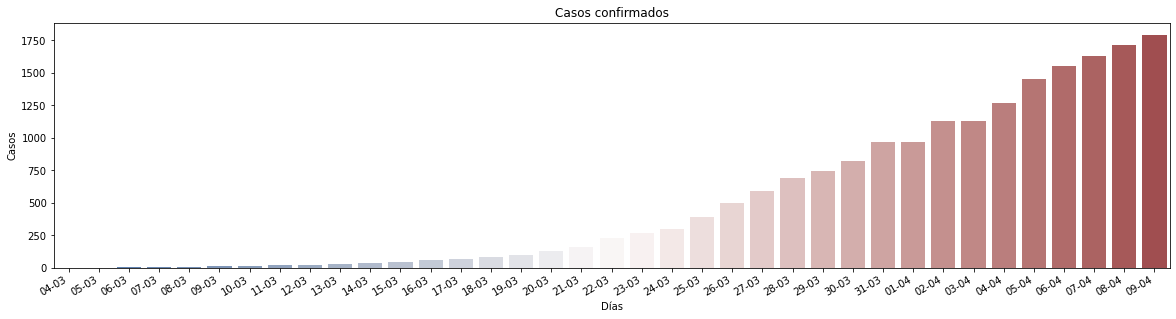

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.barplot(data=df_cases, x='date_report', y='cases_sum', palette="vlag").set(title = 'Casos confirmados')

#Fechas en etiquetas del eje x
plt.xticks(np.arange(cases_days), a_dates.format(formatter=lambda x: x.strftime('%d-%m')))
plt.gcf().autofmt_xdate()

#Etiquetas
plt.ylabel('Casos')
plt.xlabel('Días')

plt.show()

Muertes

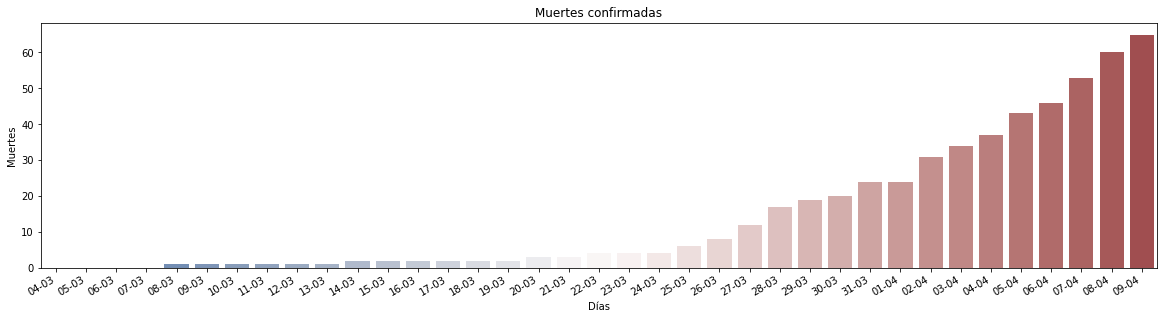

In [215]:
plt.figure(figsize=(20,5))
sns.barplot(data=df_cases, x='date_report', y='deaths_sum', palette="vlag").set(title = 'Muertes confirmadas')

#Fechas en etiquetas del eje x
plt.xticks(np.arange(cases_days), a_dates.format(formatter=lambda x: x.strftime('%d-%m')))
plt.gcf().autofmt_xdate()

#Etiquetas
plt.ylabel('Muertes')
plt.xlabel('Días')

plt.show()

Predicción

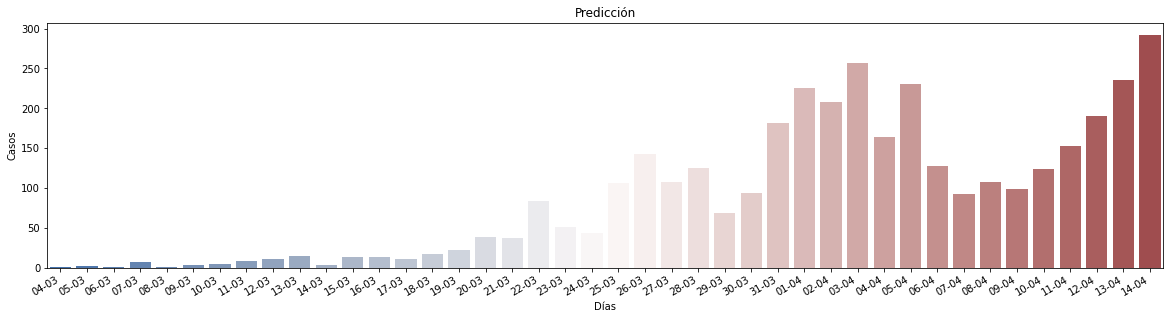

In [216]:
plt.figure(figsize=(20,5))
sns.barplot(data=df_forecast, x='date', y='cases', palette="vlag").set(title = 'Predicción')

#Etiquetas
plt.ylabel('Casos')
plt.xlabel('Días')

#Fechas en etiquetas del eje x
plt.xticks(np.arange(forecast_days), a_dates_forecast.format(formatter=lambda x: x.strftime('%d-%m')))
plt.gcf().autofmt_xdate()

plt.show()

Graficos superpuestos (Matplotlib)

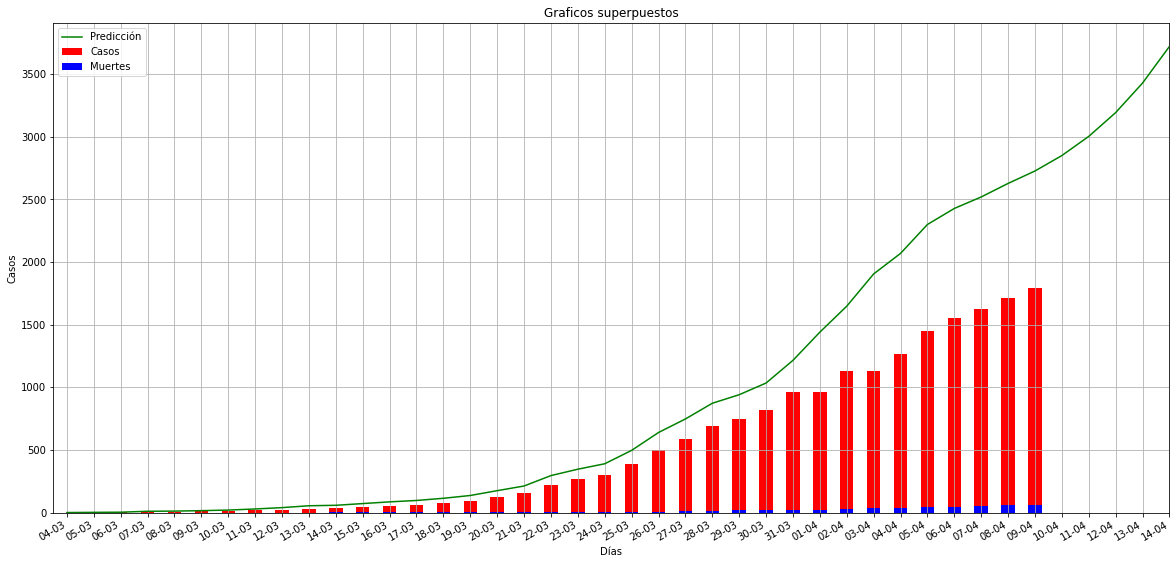

In [217]:
ax = df_cases.plot(y='cases_sum', kind='bar', color='red' ,figsize=(20,10))
df_cases.plot(y='deaths_sum', kind='bar', color='blue', ax=ax)
df_forecast.plot(y='cases_sum', kind='line', color='green', ax=ax)

#Etiquetas
plt.ylabel('Casos')
plt.xlabel('Días')
ax.set_title('Graficos superpuestos')
plt.legend(['Predicción', 'Casos', 'Muertes'])

#Fechas en etiquetas del eje x
plt.xticks(np.arange(forecast_days), a_dates_forecast.format(formatter=lambda x: x.strftime('%d-%m')))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

Graficos superpuestos (Bokeh)

In [218]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

# Inicializo Bokeh
output_notebook()

#df_dates = pd.DataFrame(a_dates)

p = figure(x_axis_type="datetime", title="Días", plot_width=800, plot_height=400)

#Casos
p.step('date_report', 'cases_sum', source=ColumnDataSource(df_cases), name="Casos confirmados", legend_label='Casos confirmados', line_color='orange', line_width=2)

#Muertes
p.step('date_report', 'deaths_sum', source=ColumnDataSource(df_cases), name="Muertes confirmadas", legend_label='Muertes confirmadas', line_color='black', line_width=2)

#Predicción
p.line('date', 'cases_sum', source=ColumnDataSource(df_forecast), name="Predicción", legend_label='Predicción de casos', line_color='red', line_width=2)
hover = HoverTool(
    tooltips=[("","$name"), ("Casos","@cases_sum{int}"), ("Día", "@date{%d-%m-%Y}")], 
    formatters= { '@date': 'datetime' }
)
p.add_tools(hover)

p.legend.location = "top_left"
show(p)